<h1> Create Keras Wide-and-Deep model </h1>

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.0
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'bucket-qwiklabs-gcp-03-d8cb7ba1a6f4'
PROJECT = 'qwiklabs-gcp-03-d8cb7ba1a6f4'
REGION = 'us-east1' #'us-central1'
SAC = 'jupyter-notebook-sac-d'
SAC_KEY_DESTINATION = '/media/mujahid7292/Data/Gcloud_Tem_SAC'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SAC'] = SAC
os.environ['SAC_KEY_DESTINATION'] = SAC_KEY_DESTINATION

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Create Keras model
<p>
First, write an input_fn to read the data.

In [4]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.1.0


In [5]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [6]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [7]:
# Build a Keras wide-and-deep model using it's functional API
def rmse(y_true, y_pred):
    """
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Helper function to handle a categorical column.
def categorical_fc(name, values):
    """
    """
    original = tf.feature_column.categorical_column_with_vocabulary_list(
        key=name,
        vocabulary_list=values
    )
    wraped = tf.feature_column.indicator_column(categorical_column=original)
    
    return original, wraped

def build_wd_model(dnn_hidden_units=[64,32], nembeds=3):
    """
    """
    # Input layer
    deep_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
            for colname in ['mother_age', 'gestation_weeks']
    }
    
    wide_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='string')
            for colname in ['is_male', 'plurality']
    }
    
    inputs = {**wide_inputs, **deep_inputs}
    
    # Feature column from inputs
    deep_fc = {
        colname: tf.feature_column.numeric_column(colname)
            for colname in ['mother_age', 'gestation_weeks']
    }
    
    wide_fc = {}
    is_male, wide_fc['is_male'] = categorical_fc(
        name='is_male', 
        values=['True','False', 'Unknown']
    )
    plurality, wide_fc['plurality'] = categorical_fc(
        name='plurality',
        values=['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']
    )
    
    # Bucketize the float fields. This makes them wide
    age_bucktes = tf.feature_column.bucketized_column(
        source_column=deep_fc['mother_age'],
        boundaries=np.arange(start=15, stop=45, step=1).tolist()
    )
    wide_fc['age_buckets'] = tf.feature_column.indicator_column(
        categorical_column=age_bucktes
    )
    
    gestation_buckets = tf.feature_column.bucketized_column(
        source_column=deep_fc['gestation_weeks'],
        boundaries=np.arange(start=17, stop=47, step=1).tolist()
    )
    wide_fc['gestation_buckets'] = tf.feature_column.indicator_column(
        categorical_column=gestation_buckets
    )
    
    # Cross all the wide column. We have to do the crossing before we one-hot encode
    crossed = tf.feature_column.crossed_column(
        keys=[is_male, plurality, age_bucktes, gestation_buckets],
        hash_bucket_size=20000
    )
    deep_fc['crossed_embeds'] = tf.feature_column.embedding_column(
        categorical_column=crossed,
        dimension=nembeds
    )
    
    # The constructor for DenseFeatures takes a list of numeric column
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    wide_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=wide_fc.values(),
        name='wide_inputs'
    )(inputs)
    deep_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=deep_fc.values(),
        name='deep_inputs'
    )(inputs)
    
    # Hidden layer for the deep side
    layers = [int(x) for x in dnn_hidden_units]
    deep = deep_inputs
    
    for layer_no, num_nodes in enumerate(layers):
        deep = tf.keras.layers.Dense(
            units=num_nodes,
            activation='relu',
            name='dnn_{}'.format(layer_no + 1)
        )(deep)
    
    deep_out = deep
    
    # Linear model for the wide side
    wide_out = tf.keras.layers.Dense(
        units=10,
        activation='relu',
        name='linear'
    )(wide_inputs)
    
    # Concatenate two sides
    both = tf.keras.layers.concatenate(
        inputs=[deep_out, wide_out],
        name='both'
    )
    
    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(
        units=1,
        activation='linear',
        name='weight'
    )(both)
    
    # Now create the keras model object
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam',loss='mse', metrics=[rmse, 'mse'])
    return model

print('Here is our wide-and-deep acrchitecture so far: \n')
model = build_wd_model()
print(model.summary())

Here is our wide-and-deep acrchitecture so far: 

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
____________________________________________________________________

## Monitor The Training In Tensorboard
Run Below Command in terminal 

<b>$ `tensorboard --logdir logs/fit/keras_wd`</b>

Open <a href='http://localhost:6006/'>Tensoarboard</a>

### We can visualize the DNN using the Keras plot_model utility.

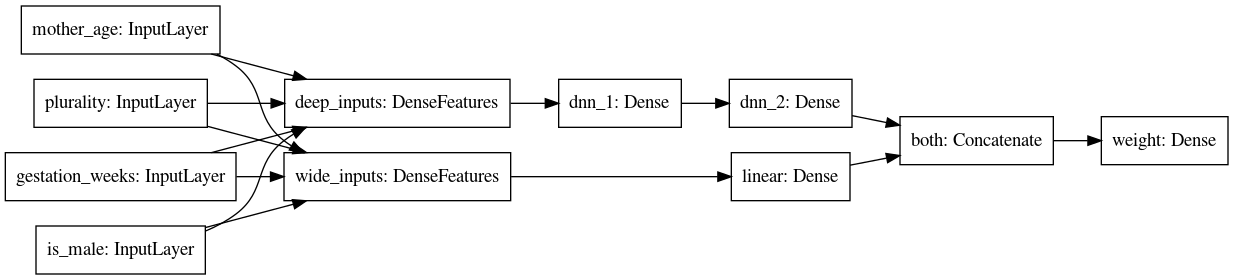

In [8]:
tf.keras.utils.plot_model(model, 'wd_model.png', show_shapes=False, rankdir='LR')

## Train and evaluate

In [9]:
import datetime

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('eval*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

#log_dir = "logs/fit/keras_wd" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/keras_wd"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 312 steps, validate for 10 steps
Epoch 1/5
312/312 [==============================] - 2s 7ms/step - loss: 1.4791 - rmse: 1.1734 - mse: 1.4791 - val_loss: 1.2169 - val_rmse: 1.1029 - val_mse: 1.2169
Epoch 2/5
312/312 [==============================] - 1s 2ms/step - loss: 1.1761 - rmse: 1.0722 - mse: 1.1761 - val_loss: 1.1519 - val_rmse: 1.0729 - val_mse: 1.1519
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 1.1691 - rmse: 1.0695 - mse: 1.1691 - val_loss: 1.2358 - val_rmse: 1.1114 - val_mse: 1.2358
Epoch 4/5
312/312 [==============================] - 1s 2ms/step - loss: 1.1588 - rmse: 1.0632 - mse: 1.1588 - val_loss: 1.1252 - val_rmse: 1.0606 - val_mse: 1.1252
Epoch 5/5
312/312 [==============================] - 1s 2ms/step - loss: 1.1241 - rmse: 1.0478 - mse: 1.1241 - val_loss: 1.2043 - val_rmse: 1.0972 - val_mse: 1.2043


## Visualize loss curve

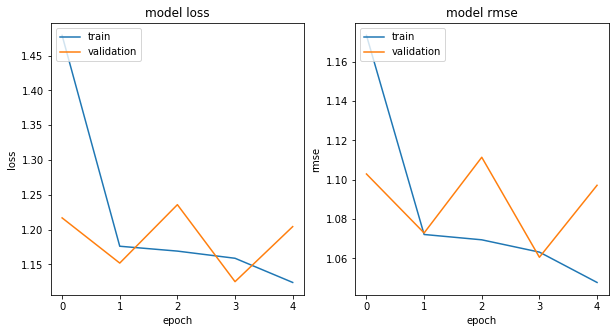

In [11]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');
plt.show()

## Save the model

In [12]:
import shutil, os, datetime
OUTPUT_DIR = './babyweight_trained_keras_wd'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function
print("Exported trained model to {}".format(EXPORT_PATH))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./babyweight_trained_keras_wd/20200418193843/assets
Exported trained model to ./babyweight_trained_keras_wd/20200418193843


In [13]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


<h2> Monitor and experiment with training </h2>

To begin TensorBoard from within AI Platform Notebooks, click the + symbol in the top left corner and select the **Tensorboard** icon to create a new TensorBoard.

In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?